In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_mac_raw = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-12-22/big-mac.csv"
)

In [3]:
df_mac_raw["year"] = pd.DatetimeIndex(df_mac_raw["date"]).year 
df_mac_raw = df_mac_raw[["date", "year", "iso_a3", "currency_code", "name", "dollar_price"]]

In [4]:
df_mac = df_mac_raw.groupby(["iso_a3", "name", "year"]).agg(
    price = ("dollar_price", "mean")
).reset_index()

group_sizes = df_mac.groupby("iso_a3").size()

keep = (group_sizes[group_sizes == 21]).index.tolist()

df_mac = df_mac[df_mac["iso_a3"].isin(keep)]
df_mac

,iso_a3,name,year,price
17,ARG,Argentina,2000,2.500000
18,ARG,Argentina,2001,2.500000
19,ARG,Argentina,2002,0.798722
20,ARG,Argentina,2003,1.423611
21,ARG,Argentina,2004,1.477966
...,...,...,...,...
862,ZAF,South Africa,2016,1.936186
863,ZAF,South Africa,2017,2.073569
864,ZAF,South Africa,2018,2.383690
865,ZAF,South Africa,2019,2.211196


In [5]:
countries = df_mac[df_mac["year"] == 2008]["iso_a3"].tolist()
HIGHLIGHTS = ["EUZ", "CHE", "DNK", "SWE", "BRA", "ARG", "GBR", "USA"]

In [6]:
df_mac_indexed_2008 = df_mac[df_mac["iso_a3"].isin(countries)]
df_mac_indexed_2008["ref_year"] = 2008

# For each country/region, obtain the price for 2008
df_price_index = df_mac_indexed_2008.groupby("iso_a3").apply(
   lambda x: x.iloc[np.where(x["year"] == 2008)]
).reset_index(drop=True)

# Rename it to 'price_index'
df_price_index.rename(columns={"price": "price_index"}, inplace=True)

# Keep only 'iso_a3' and 'price_index'
df_price_index = df_price_index[["iso_a3", "price_index"]]


# Merge
df_mac_indexed_2008 = pd.merge(df_mac_indexed_2008, df_price_index, on = "iso_a3")

# Compute relative price
df_mac_indexed_2008["price_rel"] = df_mac_indexed_2008["price"] - df_mac_indexed_2008["price_index"]

df_mac_indexed_2008["group"] = np.where(
    df_mac_indexed_2008["iso_a3"].isin(HIGHLIGHTS),
    df_mac_indexed_2008["iso_a3"],
    "other"
)
df_mac_indexed_2008["name_lab"] = np.where(
    df_mac_indexed_2008["year"] == 2020,
    df_mac_indexed_2008["name"],
    np.nan
)

df_mac_indexed_2008["group"] = pd.Categorical(
    df_mac_indexed_2008["group"], 
    ordered=True,  
    categories=sorted(HIGHLIGHTS) + ["other"]
)

In [7]:
GREY10 = "#1a1a1a"
GREY30 = "#4d4d4d"
GREY40 = "#666666"
GREY50 = "#7f7f7f"
GREY60 = "#999999"
GREY75 = "#bfbfbf"
GREY91 = "#e8e8e8"
GREY98 = "#fafafa"


COLOR_SCALE = [
    "#7F3C8D", # Euro area
    "#11A579", # CHE
    "#3969AC", # Denmark
    "#F2B701", # Sweden
    "#E73F74", # Brazil
    "#80BA5A", # Argentina
    "#E68310", # Great Britain?
    GREY50     # USA, grey
]

VLINES = np.arange(2000, 2020, 5)

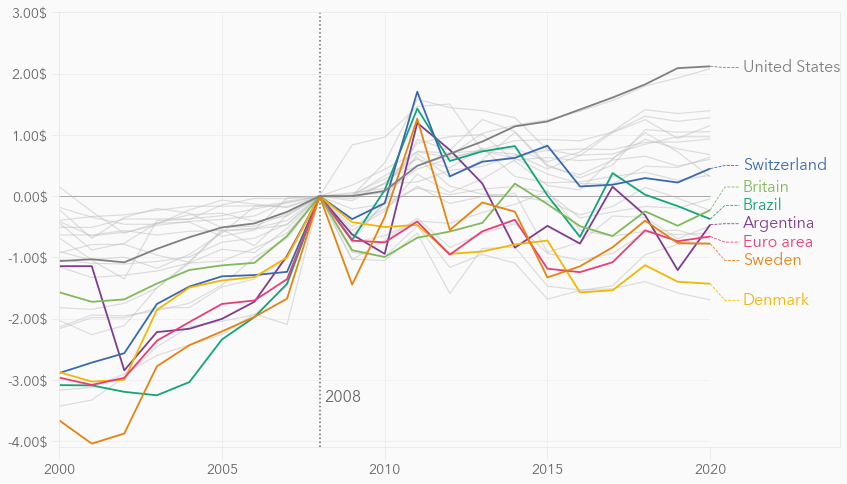

In [44]:
fig, ax = plt.subplots(figsize = (14, 8))


# Background color
fig.patch.set_facecolor(GREY98)
ax.set_facecolor(GREY98)

# Vertical lines used as scale reference
for h in VLINES:
    ax.axvline(h, color=GREY91, lw=0.6, zorder=0)
    
ax.hlines(
    y=np.arange(-4, 3), 
    xmin=2000, 
    xmax=2020,
    color=GREY91,
    lw=0.6
)

ax.hlines(
    y=0, 
    xmin=2000, 
    xmax=2020,
    color=GREY60,
    lw=0.8
)

ax.axvline(2008, color=GREY40, ls="dotted")


# Lines
df_others = df_mac_indexed_2008[df_mac_indexed_2008["group"] == "other"]
df_highlight = df_mac_indexed_2008[df_mac_indexed_2008["group"] != "other"]

for group in df_others["iso_a3"].unique():
    d = df_others[df_others["iso_a3"] == group]
    ax.plot("year", "price_rel", color=GREY75, lw=1.2, alpha=0.5, data=d, solid_capstyle="butt")


for idx, group in enumerate(df_highlight["iso_a3"].unique()):
    d = df_highlight[df_highlight["iso_a3"] == group]
    color = COLOR_SCALE[idx]
    ax.plot("year", "price_rel", color=color, lw=1.8, data=d, solid_capstyle="butt")



# Annotations
ax.text(
    x=2008.15, 
    y=-3.35, 
    s="2008", 
    fontname="Avenir Next LT Pro", 
    fontsize=16, 
    color=GREY40,
    ha="left"
)

# Positions
LABEL_X = 2021
LABEL_Y = [
    -0.45,  # ARG
    -0.15,  # BRA
    0.5,    # CHE
    -1.7,   # DNK
    -0.75,  # EUZ
    0.15,   # GBR
    -1.05,  # SWE
    2.1     # USA
]

for idx, group in enumerate(df_highlight["iso_a3"].unique()):
    data = df_highlight[(df_highlight["iso_a3"] == group) & (df_highlight["year"] == 2020)]
    color = COLOR_SCALE[idx]
    y = LABEL_Y[idx]
    text = data["name_lab"].values[0]
    yy = data["price_rel"].values[0]
    ax.plot([2020, (2020 + LABEL_X - 0.1) / 2 ,LABEL_X - 0.1], [yy, y, y], color=color, lw=0.8, ls="dashed")
    ax.text(LABEL_X, y, text, color=color, fontsize=16, weight=1000, fontfamily="Avenir Next LT Pro", va="center")


    
ax.set_xlim(2000, 2024)
ax.set_ylim(-4.1, 3)

ax.set_yticks([y for y in np.arange(-4, 4)])
ax.set_yticklabels(
    [f"{y}.00$" for y in np.arange(-4, 4)], 
    fontname="Avenir Next LT Pro", 
    fontsize=14,
    color=GREY40
);

ax.set_xticks([x for x in np.arange(2000, 2025, 5)])
ax.set_xticklabels(
    [x for x in np.arange(2000, 2025, 5)], 
    fontname= "Avenir Next LT Pro", 
    fontsize=14,
    color=GREY40
)


ax.spines["left"].set_color(GREY91)
ax.spines["bottom"].set_color(GREY91)
ax.spines["right"].set_color(GREY91)
ax.spines["top"].set_color(GREY91)

ax.tick_params(axis="x", length=12, color=GREY91)
ax.tick_params(axis="y", length=8, color=GREY91)